# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

# 计算输入数据的总元素数量
# num_inputs表示批量大小(batch size)，这里是2个样本
# np.prod(input_shape)计算每个样本的元素总数：4*5*6=120
# 所以input_size = 2*120 = 240，表示所有输入数据的元素总数
input_size = num_inputs * np.prod(input_shape)

# output_dim=3是输出特征数
# weight_size = 120*3 = 360，表示权重矩阵的元素总数
weight_size = output_dim * np.prod(input_shape)

# 创建测试用的输入数据x（wb同理）
# 使用linspace生成从-0.1到0.5的等间距数值，总共input_size个
# 然后将其重塑为(num_inputs=2, 4, 5, 6)的形状，表示2个样本，每个样本是4x5x6的数据
x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [5]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


**Inline Question 1**

我们只要求您实现ReLU，但神经网络中可以使用多种不同的激活函数，每种都有其优缺点。特别是，激活函数常见的一个问题是在反向传播过程中出现零（或接近零）梯度流。以下激活函数中，哪些存在这个问题？如果考虑一维情况，什么类型的输入会导致这种行为？

1. Sigmoid
2. ReLU
3. Leaky ReLU

$\color{blue}{\textit Your Answer:}$

ReLU.

如何选择激活函数?

**一、三种激活函数Sigmoid, ReLU, Leaky ReLU的表达式及优缺点分析**

1. Sigmoid

   表达式：
   $$
   y = σ(x) = \frac{1}{ 1 + e^{-x}}
   $$
   导数：
   $$
   σ'(x) = σ(x)·(1-σ(x))
   $$
   优点：

   - 输出范围固定在 (0, 1)，可解释为概率。

   - 单调平滑，对小输入有一定增益。

   缺点：

   - 当 |x| 较大时，σ(x)→0 或 →1，σ′(x)→0，导致“梯度消失”，训练深层网络时前面层几乎收不到梯度。
   - y∈(0,1)，输出均 >0，不以 0 为中心，可能导致上下层梯度震荡，影响收敛速度。

2. ReLU (Rectified Linear Unit)

   表达式：
   $$
   y = max(0, x)
   $$
   导数：
   $$
   f'(x) = \begin{cases}
   1, & \text{if } x > 0 \\
   0, & \text{if } x \leq 0
   \end{cases}
   $$
   优点：

   - 计算简单、高效；在正区间梯度恒为 1，不会消失，有助于深层网络训练。
   - 非线性函数, 能提高模型的稀疏性和表达力。

   缺点：

   - 在 x ≤ 0 时梯度恒为 0，可能出现“死神经元”（Dead ReLU）：一旦权重更新使某单元长期落在负区间，便永远得不到梯度更新。
   - 在原点处不可微，实践中通常需要设子梯度。

3. Leaky ReLU

   表达式：（常见 α≈0.01）
   $$
   f(x) = \begin{cases}
   x, & \text{if } x \geq 0 \\
   \alpha x, & \text{if } x < 0
   \end{cases}
   $$


   导数：
$$
   f'(x) = \begin{cases}
   1, & \text{if } x > 0 \\
   \alpha, & \text{if } x < 0
   \end{cases}
$$
   优点：

   - 保留了 ReLU 在正区间的优点，同时在负区间也有一个小斜率 α，避免了“死神经元”现象。
   - 数值稳定，且负区间梯度虽小但不为 0，有助于网络对负输入也能学习。

   缺点：

   - 需要手动设定超参数 α，不同任务可能需要不同 α。

Sigmoid 适合二分类输出或小网络，但深层网络易梯度消失。

ReLU 简单高效，是目前最广泛使用的隐藏层激活，但需注意死神经元问题。

Leaky ReLU 在 ReLU 基础上对负区间添加了斜率，在防止神经元死亡上更稳健，但多出一个超参数。

**二、为什么不使用函数y=x或者y=x*x或者一些其他的不会因为输入过大过小导致饱和的非线性函数作为激活函数?**

线性函数 y=x:

- 任意多层线性变换（Wx+b）叠加，依旧等价于一个单层线性变换；网络失去了“深度”优势，无法拟合非线性决策边界。

纯二次函数 y=x²

- 梯度消失／爆炸：当输入 x 很小（|x|≪1）时，梯度 y′=2x 也趋近于 0，导致前面层更新缓慢；当输入 x 很大时，梯度反而会变得非常大，容易导致梯度爆炸，不利于优化。
- 非中心化输出：x² 的输出始终 ≥0，会让后续层的输入正偏移，加剧训练时的梯度震荡或减慢收敛。
- 非单调性和对称性差：x² 对正负 x 给出相同输出，但在分类或拟合任务中，输入正负信息往往要区别对待。

其他“看似不饱和”的函数（如高次多项式、某些根号函数等）

- 多项式／根号类非线性要么饱和（导数→0），要么导数→∞，都可能导致梯度消失或爆炸。
- 非单调或非零中心问题：非零中心会让网络各层的激活值分布偏移，训练更不稳定。
- 数值稳定性和计算成本：高次函数、分段复杂函数往往需要额外的数值保护（溢出／下溢），并且计算开销大。

为什么我们常用 ReLU、Leaky ReLU、ELU、Swish 等函数？

- 线性分段（ReLU）保持了正区间恒定梯度 ，不会梯度爆炸，也不容易梯度消失；新一代激活（Swish、GELU、ELU、SELU 等）之所以被提出来，往往是在“非饱和”与“单调可导”之间做了更好的折中；这些函数既保留了 ReLU 的线性区，又在负区间给了平滑小梯度。
- 输出是“零中心”分布（正、负值都有），有助于中间层保持更平衡的激活统计量；
- 计算极为简单、数值稳定、硬件友好。

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [8]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax
Now implement the loss and gradient for softmax in the `softmax_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py`. Other loss functions (e.g. `svm_loss`) can also be implemented in a modular way, however, it is not required for this assignment.

You can make sure that the implementations are correct by running the following:

In [34]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)


dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [118]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None
data
##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-4,
                    },
                    lr_decay=0.95,
                    num_epochs=5, batch_size=200,
                    print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1225) loss: 2.303842
(Epoch 0 / 5) train acc: 0.084000; val_acc: 0.093000
(Iteration 101 / 1225) loss: 2.261059
(Iteration 201 / 1225) loss: 2.187192
(Epoch 1 / 5) train acc: 0.239000; val_acc: 0.257000
(Iteration 301 / 1225) loss: 2.023270
(Iteration 401 / 1225) loss: 1.949115
(Epoch 2 / 5) train acc: 0.307000; val_acc: 0.293000
(Iteration 501 / 1225) loss: 1.972706
(Iteration 601 / 1225) loss: 2.019295
(Iteration 701 / 1225) loss: 1.884547
(Epoch 3 / 5) train acc: 0.320000; val_acc: 0.325000
(Iteration 801 / 1225) loss: 1.755867
(Iteration 901 / 1225) loss: 1.923129
(Epoch 4 / 5) train acc: 0.392000; val_acc: 0.351000
(Iteration 1001 / 1225) loss: 1.808719
(Iteration 1101 / 1225) loss: 1.902346
(Iteration 1201 / 1225) loss: 1.716699
(Epoch 5 / 5) train acc: 0.370000; val_acc: 0.367000


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

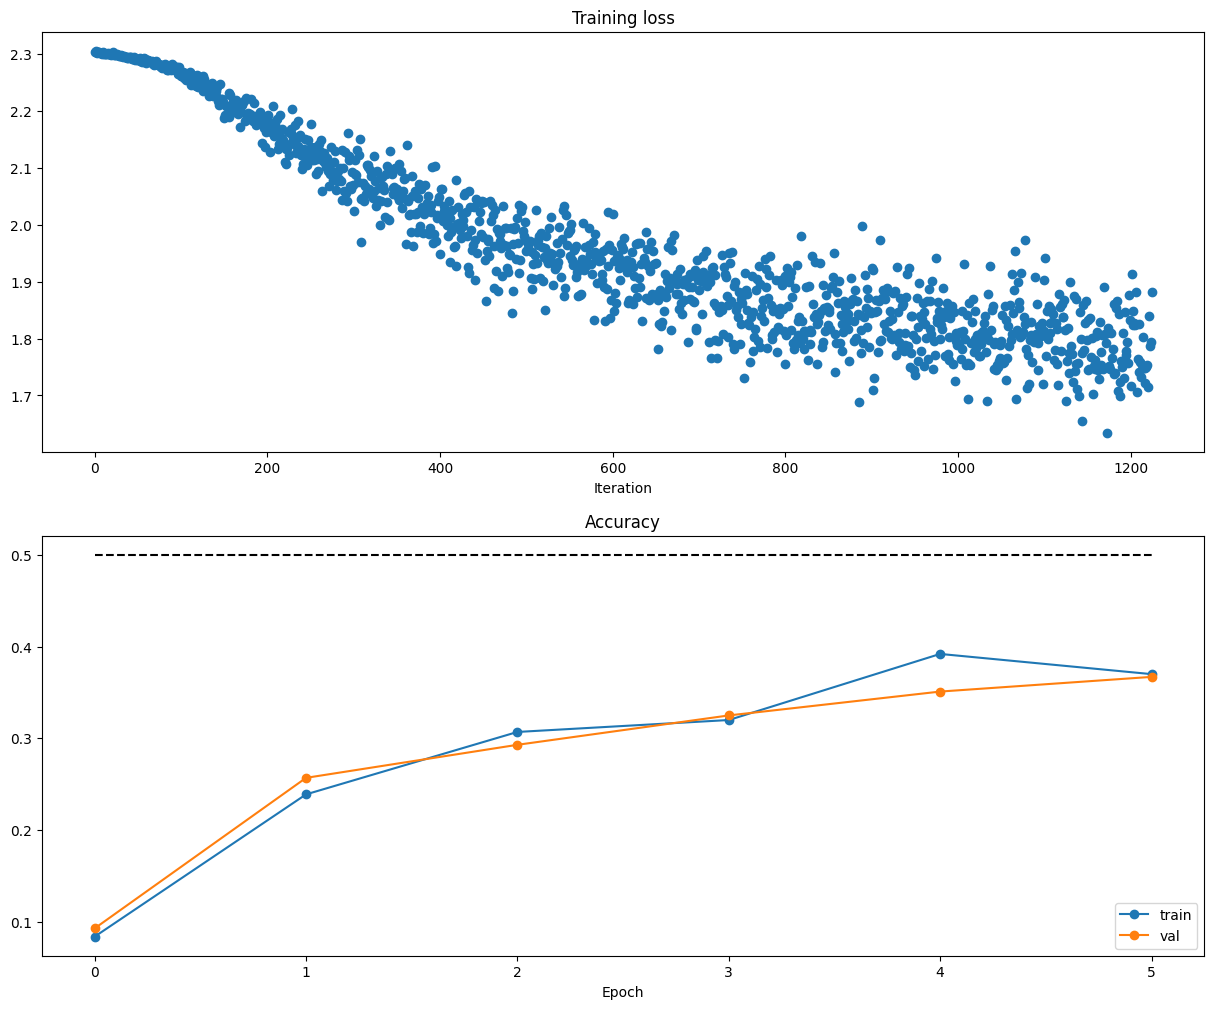

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

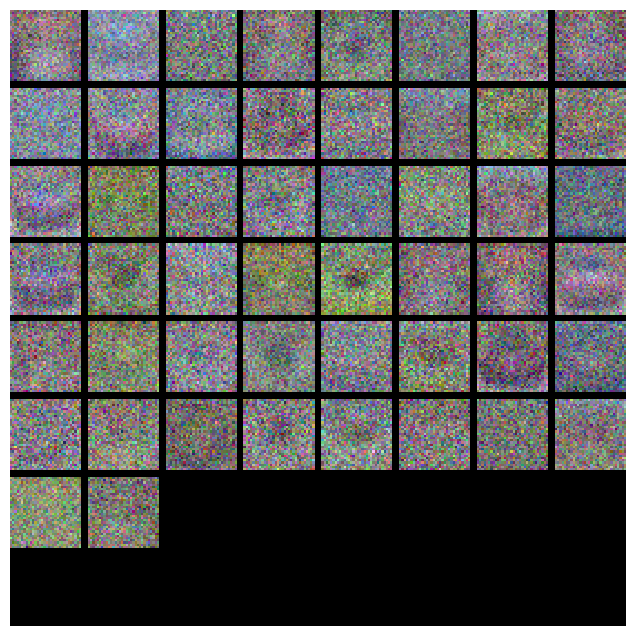

In [ ]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**问题所在**。观察上面的可视化结果，我们发现损失函数几乎是线性下降的，这似乎表明学习率可能太低。此外，训练准确率和验证准确率之间没有差距，这表明我们使用的模型容量较低，我们应该增加其规模。另一方面，如果模型过大，我们预计会看到更多的过拟合现象，这将表现为训练准确率和验证准确率之间存在很大的差距。

**调参**。调整超参数并培养它们如何影响最终性能的直觉是使用神经网络的重要部分，所以我们希望你多加练习。在下面，你应该尝试不同的超参数值，包括隐藏层大小、学习率、训练轮数和正则化强度。你也可以考虑调整学习率衰减，但使用默认值应该也能获得不错的性能。

**预期结果**。你的目标应该是在验证集上达到超过48%的分类准确率。我们最好的网络在验证集上达到了超过52%的准确率。

**实验**：你在这个练习中的目标是使用全连接神经网络在CIFAR-10上获得尽可能好的结果（52%可以作为参考）。随意实现你自己的技术（例如使用PCA降低维度，或添加dropout，或向求解器添加功能等）。

In [ ]:
best_model = None
best_val_acc = 0


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
i = 1
for lr in [1e-3]:
    for hidden_size in [50, 100, 200]:
        for num_epochs in [5, 10, 20]:
            for reg in [1e-1, 1e-2, 1e-3, 1e-4]:
                model = TwoLayerNet(input_size, hidden_size, num_classes, reg = reg)
                solver = Solver(model, data,
                                update_rule='sgd',
                                optim_config={
                                    'learning_rate': lr,
                                },
                                lr_decay=0.95,
                                num_epochs=num_epochs, batch_size=1000,
                                print_every=1000)
                print("\n-----------第{}个模型开始训练-----------".format(i))
                solver.train()
                print("----------------训练结束---------------".format(i))
                if solver.best_val_acc > best_val_acc:
                    best_val_acc = solver.best_val_acc
                    best_model = model
                    best_solver = solver
                    print("新模型产生")
                i += 1

print("最佳模型超参数:")
print("隐藏层大小:", best_model.params['W1'].shape[1])
print("学习率:", best_solver.optim_config['learning_rate'])
print("正则化强度:", best_model.reg)
print("验证集准确率:", best_val_acc)
print("训练轮数:", best_solver.num_epochs)
print("批量大小:", best_solver.batch_size)
print("学习率衰减:", best_solver.lr_decay)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################


-----------第1个模型开始训练-----------
(Iteration 1 / 245) loss: 2.310219
(Epoch 0 / 5) train acc: 0.114000; val_acc: 0.090000
(Epoch 1 / 5) train acc: 0.290000; val_acc: 0.298000
(Epoch 2 / 5) train acc: 0.349000; val_acc: 0.364000
(Epoch 3 / 5) train acc: 0.393000; val_acc: 0.383000
(Epoch 4 / 5) train acc: 0.397000; val_acc: 0.402000
(Epoch 5 / 5) train acc: 0.426000; val_acc: 0.420000
----------------训练结束---------------
新模型产生

-----------第2个模型开始训练-----------
(Iteration 1 / 245) loss: 2.302714
(Epoch 0 / 5) train acc: 0.119000; val_acc: 0.107000
(Epoch 1 / 5) train acc: 0.293000; val_acc: 0.298000
(Epoch 2 / 5) train acc: 0.376000; val_acc: 0.363000
(Epoch 3 / 5) train acc: 0.400000; val_acc: 0.391000
(Epoch 4 / 5) train acc: 0.413000; val_acc: 0.399000
(Epoch 5 / 5) train acc: 0.413000; val_acc: 0.423000
----------------训练结束---------------
新模型产生

-----------第3个模型开始训练-----------
(Iteration 1 / 245) loss: 2.301995
(Epoch 0 / 5) train acc: 0.124000; val_acc: 0.122000
(Epoch 1 / 5) train acc

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [ ]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.53


In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.513


In [ ]:
# Save best model
best_model.save("best_two_layer_net.npy")

best_two_layer_net.npy saved.


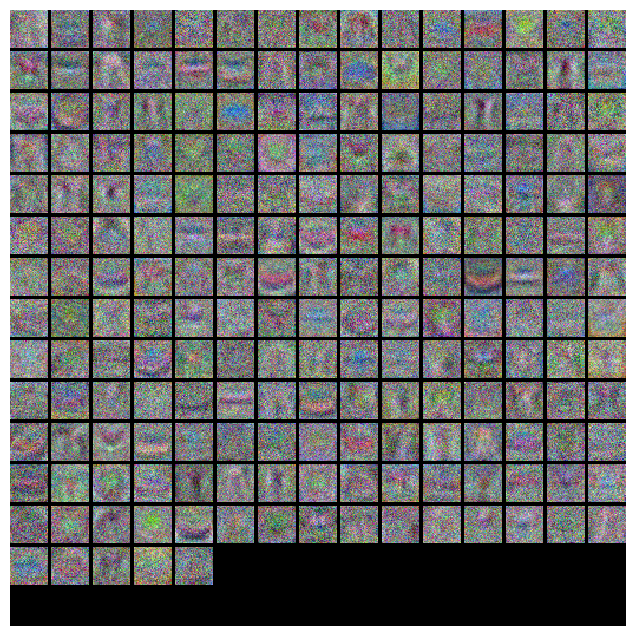

In [ ]:

show_net_weights(best_model)

**Inline Question 2**

现在你已经训练好了一个神经网络分类器，可能会发现测试集准确率远低于训练集准确率。我们可以通过以下哪些方法来缩小这个差距？

1. 在更大的数据集上训练。
2. 增加更多的隐藏单元。
3. 增加正则化强度。

$\color{blue}{\textit Your Answer:}$

1 和 3.

本质是解决过拟合的问题.

1. 在更大的数据集上训练，可以让模型见到更多样本、减少对训练集的过度记忆，从而提升泛化能力

2. “增加更多的隐藏单元” 会提升模型容量，反而更容易在训练集上拟合得很好，但在测试集上表现更差. 我们要做的是尽量简化模型. 

3. 增加正则化强度（如增大 L2 正则化系数、增加 Dropout 比例等），可以抑制模型过度拟合训练数据，也能缩小训练／测试误差之间的差距

   注: Dropout 的工作原理

   在每一次前向传播（training mode）时，对于网络中某一层的每个神经元（或激活值），以概率 p 将其“丢弃”掉，也就是令该神经元的输出变为 0；以概率 (1–p) 保留并按比例缩放。丢弃神经元迫使网络在不同的子网络（dropout 掩码不同）上学习，更不容易依赖某个特征通道。网络变得更健壮，不易被单个神经元的噪声或异常值左右。